In [1]:
%load_ext watermark
%watermark -u -n -t -z -v -p numpy,scipy,neupy,scikit-learn,matplotlib

last updated: Mon Aug 21 2017 21:23:56 CEST

CPython 2.7.13
IPython 5.3.0

numpy 1.13.1
scipy 0.19.0
neupy 0.6.0.dev
scikit-learn 0.18.1
matplotlib 1.5.3


/Users/itdxer/.pyenv/versions/2.7.13/envs/neupy27/lib/python2.7/site-packages/watermark/watermark.py:146: DeprecationWarning: Importing scikit-learn as `scikit-learn` has been depracated and will not be supported anymore in v1.7.0. Please use the package name `sklearn` instead.
  DeprecationWarning)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## VGG19

In [3]:
from neupy import architectures, environment

environment.speedup()
vgg19 = architectures.vgg19()

## Download VGG19 pre-trained weights

In [4]:
import os
import sys

CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
CNN_EXAMPLE_FILES = os.path.join(CURRENT_DIR, '..', 'examples', 'cnn')
VGG19_WEIGHTS_FILE = os.path.join(CNN_EXAMPLE_FILES, 'files', 'vgg19.pickle')

sys.path.append(CNN_EXAMPLE_FILES)

In [5]:
# requires also modules: requests and tqdm
from imagenet_tools import download_file, load_image, deprocess

/Users/itdxer/.pyenv/versions/2.7.13/envs/neupy27/lib/python2.7/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [6]:
import os
from neupy import storage

if not os.path.exists(VGG19_WEIGHTS_FILE):
    download_file(
        url="http://neupy.s3.amazonaws.com/tensorflow/imagenet-models/vgg19.pickle",
        filepath=VGG19_WEIGHTS_FILE,
        description='Downloading weights')

storage.load(vgg19, VGG19_WEIGHTS_FILE)

## Visualize learned features by different filters in different layers

conv5_4 layer: 100%|██████████| 5/5 [02:10<00:00, 26.09s/it]


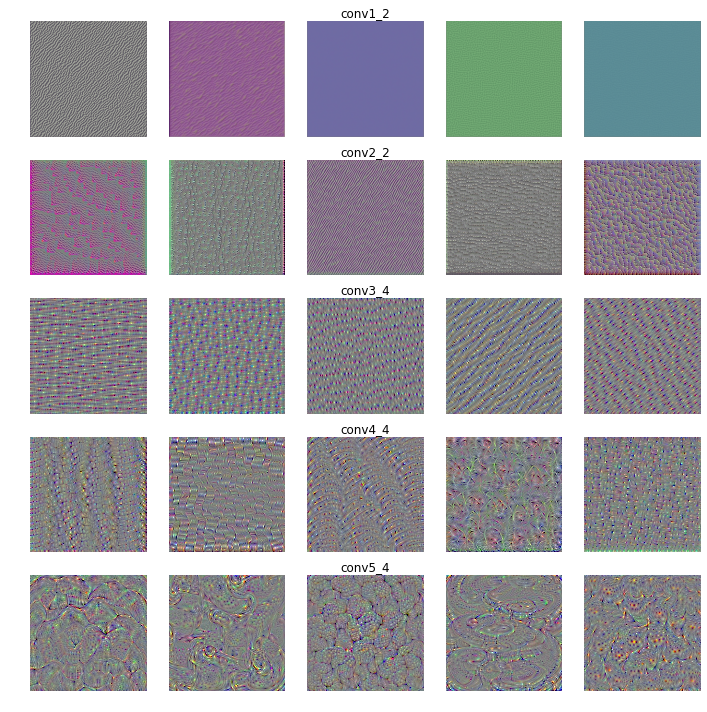

In [7]:
from itertools import product
import theano
import theano.tensor as T
import numpy as np
from tqdm import tqdm

def normalize(input_img_data):
    x = input_img_data[0]
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

layer_names = ('conv1_2', 'conv2_2', 'conv3_4', 'conv4_4', 'conv5_4')
fig, axes = plt.subplots(len(layer_names), 5, figsize=(12, 12))

for i, output_layer_name in enumerate(layer_names):
    desc = "{} layer".format(output_layer_name)
    
    x = T.tensor4()
    res = vgg19.end(output_layer_name).output(x)
    row_axes = axes[i]
    
    for j in tqdm(list(range(5)), desc=desc):
        loss = T.mean(res[:, j, :, :])
        grad = T.grad(loss, x)
        grad /= (T.sqrt(T.mean(T.square(grad))) + 1e-7)
        iterate = theano.function([x], [loss, grad])

        # we start from a gray image with some noise
        input_img_data = (np.random.random((1, 3, 224, 224)) * 20 + 128).astype(np.float32)

        step = 100.
        for _ in range(20):
            loss_value, grads_value = iterate(input_img_data)
            input_img_data = input_img_data + grads_value * step

        input_img_data = normalize(input_img_data)
        
        row_axes[j].imshow(input_img_data[:, :, ::-1])
        row_axes[j].axis('off')
        
    row_axes[2].set_title(output_layer_name)

## Saliency map

In [8]:
dog = load_image('images/dog.jpg', image_size=(256, 256), crop_size=(224, 224))

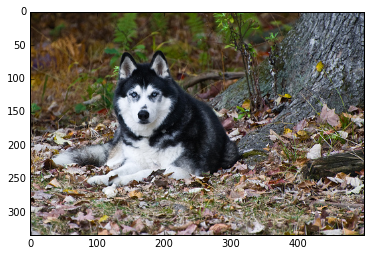

In [9]:
from scipy.misc import imread
plt.imshow(imread('images/dog.jpg'));

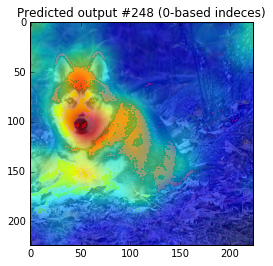

In [10]:
from neupy import plots

plt.imshow(-deprocess(dog[0]))
plots.saliency_map(vgg19, dog[0], alpha=0.6, sigma=10);

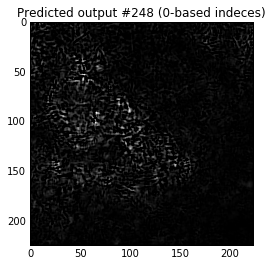

In [11]:
plots.saliency_map(vgg19, dog[0], mode='raw', vmin=0);